In [2]:

pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from sklearn_extra.cluster import KMedoids  # Import K-Medoids
from haversine import haversine

In [4]:
# Define the dataset path
dataset_path = r"C:\Users\alvia\Downloads\mfds_data"

# Initialize lists to store image data and labels
data = []
labels = []

# Get the list of folders in the dataset
folders = os.listdir(dataset_path)

# Loop through each folder and images inside them
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Check if it's a file (not a subdirectory)
            if os.path.isfile(image_path):
                image = load_img(image_path, target_size=(64, 64))
                image_array = img_to_array(image)
                data.append(image_array)
                labels.append(folder)

# Mengubah data dan label menjadi array numpy
data = np.array(data)
labels = np.array(labels)

In [5]:
# Mengubah label menjadi nilai numerik
label_mapping = {label: index for index, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_mapping[label] for label in labels])

In [6]:
# Melakukan split dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

In [7]:
# Normalisasi data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
# Hitung jarak Haversine antara semua pasangan gambar dalam dataset
distances_train = []
for i in range(len(X_train)):
    row_distances = []
    for j in range(len(X_train)):
        if i == j:
            row_distances.append(0.0)
        else:
            # Ubah koordinat gambar menjadi (latitude, longitude)
            # Ganti ini dengan koordinat yang sesuai dengan data Anda
            coord1 = (42.12345, -70.12345)  # Koordinat gambar i
            coord2 = (41.23456, -71.2345)  # Koordinat gambar j
            distance = haversine(coord1, coord2)
            row_distances.append(distance)
    distances_train.append(row_distances)

# Konversi distances_train menjadi array numpy
distances_train = np.array(distances_train)

In [9]:
# Perform K-Medoids clustering dengan metrik Haversine
n_clusters = len(label_mapping)
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42)
cluster_labels_train = kmedoids.fit_predict(distances_train)

In [10]:
# Membangun model CNN
image_input = Input(shape=(64, 64, 3), name='image_input')
cluster_label_input = Input(shape=(1,), name='cluster_label_input')

# Define CNN layers
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(maxpool2)
dense1 = Dense(64, activation='relu')(flatten)

# Merge image features and cluster labels
merged = Concatenate()([dense1, cluster_label_input])

# Add classification layers
dense2 = Dense(n_clusters + len(label_mapping), activation='relu')(merged)
output = Dense(len(label_mapping), activation='softmax')(dense2)

In [11]:
# Create the model
model = Model(inputs=[image_input, cluster_label_input], outputs=output)

In [12]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Menghitung prediksi pada data uji
distances_test = []
for i in range(len(X_test)):
    row_distances = []
    for j in range(len(X_train)):
        # Hitung jarak Haversine antara data uji dan data latih
        # Ubah koordinat gambar menjadi (latitude, longitude)
        # Ganti ini dengan koordinat yang sesuai dengan data Anda
        coord1 = (42.12345, -70.12345)  # Koordinat gambar uji i
        coord2 = (41.23456, -71.2345)  # Koordinat data latih j
        distance = haversine(coord1, coord2)
        row_distances.append(distance)
    distances_test.append(row_distances)

In [14]:
# Train model
history = model.fit([X_train, cluster_labels_train], y_train, epochs=10, batch_size=32, validation_data=([X_test, kmedoids.predict(distances_test)], y_test))

Epoch 1/10
100/100 [==============================] - 13s 123ms/step - loss: 1.7131 - accuracy: 0.2919 - val_loss: 1.3486 - val_accuracy: 0.4363
Epoch 2/10
100/100 [==============================] - 12s 115ms/step - loss: 1.0333 - accuracy: 0.6228 - val_loss: 0.8346 - val_accuracy: 0.6875
Epoch 3/10
100/100 [==============================] - 11s 112ms/step - loss: 0.8110 - accuracy: 0.7022 - val_loss: 0.8589 - val_accuracy: 0.6925
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.5393 - accuracy: 0.8122 - val_loss: 0.6398 - val_accuracy: 0.7588
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3750 - accuracy: 0.8678 - val_loss: 0.4513 - val_accuracy: 0.8388
Epoch 6/10
100/100 [==============================] - 11s 111ms/step - loss: 0.2930 - accuracy: 0.8984 - val_loss: 0.4414 - val_accuracy: 0.8550
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.2179 - accuracy: 0.9287 - val_loss: 0.5064 - val_ac

In [15]:
# Konversi distances_test menjadi array numpy
distances_test = np.array(distances_test)

y_pred = model.predict([X_test, kmedoids.predict(distances_test)])
y_pred_classes = np.argmax(y_pred, axis=1)

25/25 [==============================] - 1s 26ms/step


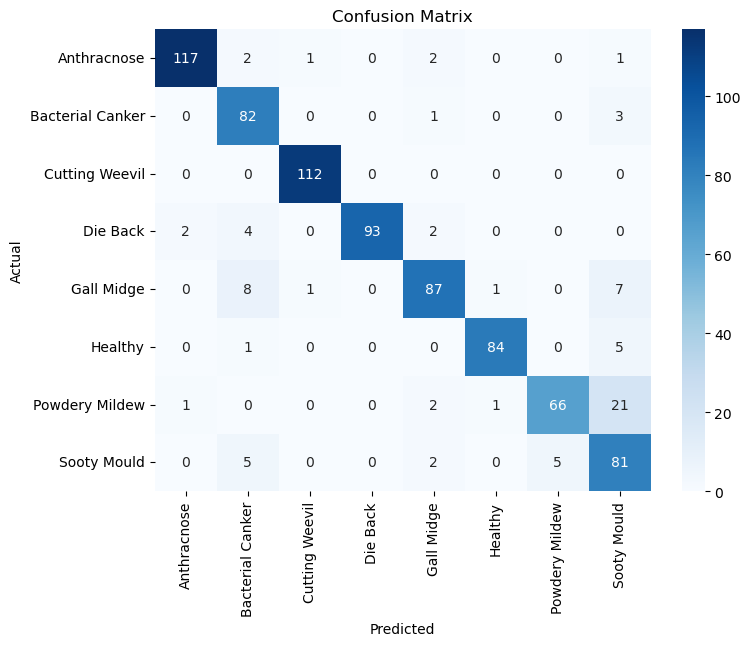

In [16]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualisasi confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Menghitung laporan klasifikasi
classification_result = classification_report(y_test, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)


In [21]:
print(classification_result)

{'Anthracnose': {'precision': 0.975, 'recall': 0.9512195121951219, 'f1-score': 0.9629629629629629, 'support': 123.0}, 'Bacterial Canker': {'precision': 0.803921568627451, 'recall': 0.9534883720930233, 'f1-score': 0.8723404255319148, 'support': 86.0}, 'Cutting Weevil': {'precision': 0.9824561403508771, 'recall': 1.0, 'f1-score': 0.9911504424778761, 'support': 112.0}, 'Die Back': {'precision': 1.0, 'recall': 0.9207920792079208, 'f1-score': 0.9587628865979382, 'support': 101.0}, 'Gall Midge': {'precision': 0.90625, 'recall': 0.8365384615384616, 'f1-score': 0.87, 'support': 104.0}, 'Healthy': {'precision': 0.9767441860465116, 'recall': 0.9333333333333333, 'f1-score': 0.9545454545454545, 'support': 90.0}, 'Powdery Mildew': {'precision': 0.9295774647887324, 'recall': 0.7252747252747253, 'f1-score': 0.8148148148148148, 'support': 91.0}, 'Sooty Mould': {'precision': 0.6864406779661016, 'recall': 0.8709677419354839, 'f1-score': 0.7677725118483412, 'support': 93.0}, 'accuracy': 0.9025, 'macro av

In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Buat DataFrame dari hasil laporan klasifikasi
results_df = pd.DataFrame(classification_result).transpose()

# Hitung nilai akurasi
accuracy = accuracy_score(y_test, y_pred_classes)

# Tambahkan nilai akurasi sebagai baris terakhir di DataFrame
accuracy_row = pd.DataFrame({'precision': [None], 'recall': [None], 'f1-score': [None], 'support': [None], 'accuracy': [accuracy]})
results_df = pd.concat([results_df, accuracy_row])

# Menampilkan DataFrame sebagai tabel
print("Classification Report:")
print(results_df[['precision', 'recall', 'f1-score', 'support', 'accuracy']])

# Menampilkan rata-rata Precision, Recall, dan F1 Score
average_metrics = results_df[['precision', 'recall', 'f1-score']].mean()
print("\nAverage Metrics:")
print(average_metrics)

# Menampilkan Accuracy
print(f"\nAccuracy: {accuracy}")

Classification Report:
                  precision    recall  f1-score   support  accuracy
Anthracnose        0.975000  0.951220  0.962963  123.0000       NaN
Bacterial Canker   0.803922  0.953488  0.872340   86.0000       NaN
Cutting Weevil     0.982456  1.000000  0.991150  112.0000       NaN
Die Back           1.000000  0.920792  0.958763  101.0000       NaN
Gall Midge         0.906250  0.836538  0.870000  104.0000       NaN
Healthy            0.976744  0.933333  0.954545   90.0000       NaN
Powdery Mildew     0.929577  0.725275  0.814815   91.0000       NaN
Sooty Mould        0.686441  0.870968  0.767773   93.0000       NaN
accuracy           0.902500  0.902500  0.902500    0.9025       NaN
macro avg          0.907549  0.898952  0.899044  800.0000       NaN
weighted avg       0.913356  0.902500  0.904062  800.0000       NaN
0                       NaN       NaN       NaN       NaN    0.9025

Average Metrics:
precision    0.907618
recall       0.899597
f1-score     0.899814
dtype: fl

In [25]:
# Mendapatkan nilai Precision dan Recall untuk setiap kelas
precision = []
recall = []
class_labels = list(label_mapping.keys())

for label in class_labels:
    precision.append(classification_result[label]['precision'])
    recall.append(classification_result[label]['recall'])


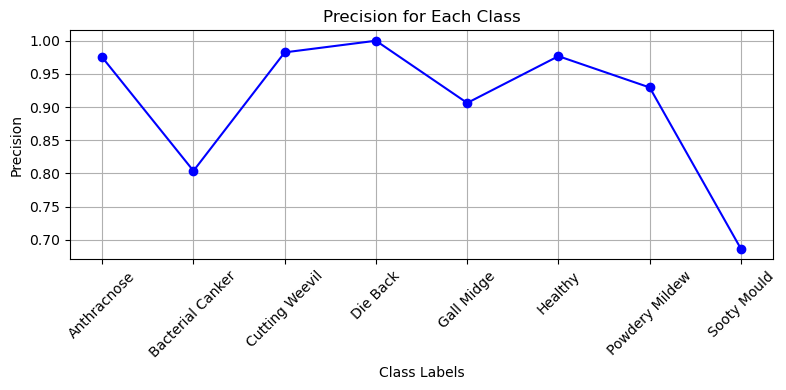

In [26]:
# Membuat grafik garis untuk Precision
plt.figure(figsize=(8, 4))
plt.plot(class_labels, precision, marker='o', linestyle='-', color='b')
plt.xlabel('Class Labels')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

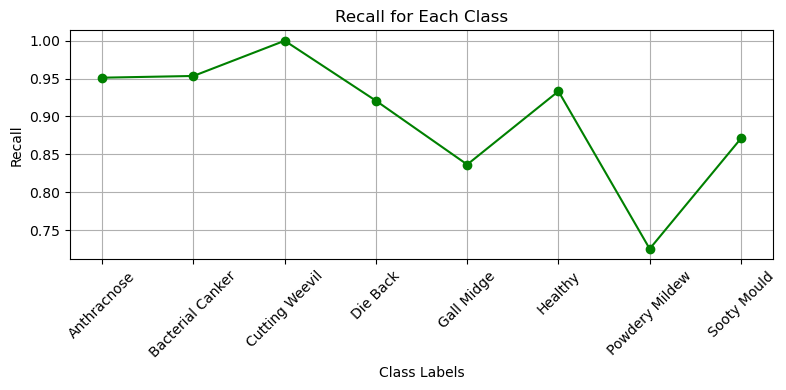

In [27]:
# Membuat grafik garis untuk Recall
plt.figure(figsize=(8, 4))
plt.plot(class_labels, recall, marker='o', linestyle='-', color='g')
plt.xlabel('Class Labels')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

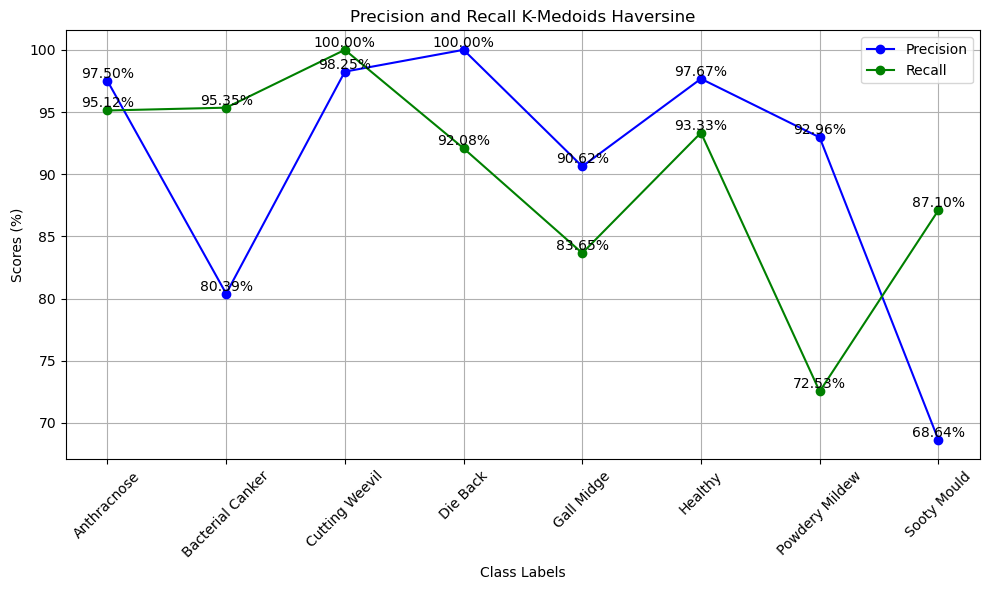

In [28]:
class_labels = label_mapping.keys()
precision = [p * 100 for p in precision]  # Ubah ke persen dengan 2 digit desimal
recall = [r * 100 for r in recall]  # Ubah ke persen dengan 2 digit desimal

# Mengatur posisi x untuk titik-titik
x = range(len(class_labels))

# Buat grafik Precision sebagai line chart
plt.figure(figsize=(10, 6))
plt.plot(x, precision, marker='o', linestyle='-', color='b', label='Precision')
plt.plot(x, recall, marker='o', linestyle='-', color='g', label='Recall')

# Menambahkan angka di setiap titik
for i, j in zip(x, precision):
    plt.text(i, j, f'{j:.2f}%', ha='center', va='bottom')

for i, j in zip(x, recall):
    plt.text(i, j, f'{j:.2f}%', ha='center', va='bottom')

# Label sumbu x dan nama kelas
plt.xlabel('Class Labels')
plt.ylabel('Scores (%)')
plt.title('Precision and Recall K-Medoids Haversine')
plt.xticks(x, class_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
